#1. Darknet Clone
Runtime => GPU

In [1]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15308, done.
remote: Total 15308 (delta 0), reused 0 (delta 0), pack-reused 15308
Receiving objects: 100% (15308/15308), 13.69 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (10404/10404), done.


In [2]:
%cd darknet

/content/darknet


In [3]:
!ls -al

total 268
drwxr-xr-x 14 root root  4096 Sep  9 04:57 .
drwxr-xr-x  1 root root  4096 Sep  9 04:57 ..
drwxr-xr-x  4 root root  4096 Sep  9 04:57 3rdparty
drwxr-xr-x  3 root root  4096 Sep  9 04:57 build
-rwxr-xr-x  1 root root 27008 Sep  9 04:57 build.ps1
drwxr-xr-x  3 root root  4096 Sep  9 04:57 cfg
drwxr-xr-x  2 root root  4096 Sep  9 04:57 .circleci
drwxr-xr-x  3 root root  4096 Sep  9 04:57 cmake
-rw-r--r--  1 root root 24576 Sep  9 04:57 CMakeLists.txt
-rw-r--r--  1 root root  1406 Sep  9 04:57 DarknetConfig.cmake.in
-rw-r--r--  1 root root  9469 Sep  9 04:57 darknet_images.py
-rw-r--r--  1 root root 10828 Sep  9 04:57 darknet.py
-rw-r--r--  1 root root  6747 Sep  9 04:57 darknet_video.py
drwxr-xr-x  3 root root  4096 Sep  9 04:57 data
drwxr-xr-x  8 root root  4096 Sep  9 04:57 .git
drwxr-xr-x  4 root root  4096 Sep  9 04:57 .github
-rw-r--r--  1 root root   686 Sep  9 04:57 .gitignore
-rwxr-xr-x  1 root root   110 Sep  9 04:57 image_yolov3.sh
-rwxr-xr-x  1 root root   110 Sep  9 

In [4]:
# change makefile to have GPU,OPENCV, CUDNN enabled
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
#Compile Sources
!make

In [6]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-09-09 04:58:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  65.1MB/s    in 3.9s    

2021-09-09 04:58:56 (60.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



#2. Tracking

In [8]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [9]:
min_confidence = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

file_name = 'cabc30fc-e7726578.mp4'

In [10]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

In [11]:
classes = []
with open(name_file, 'r') as f:
     classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [7]:
# cabc30fc-e7726578.mp4

from google.colab import files
files.upload()

Saving cabc30fc-e7726578.mp4 to cabc30fc-e7726578.mp4


In [14]:
layers_names = net.getLayerNames()
output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()] 

In [12]:
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

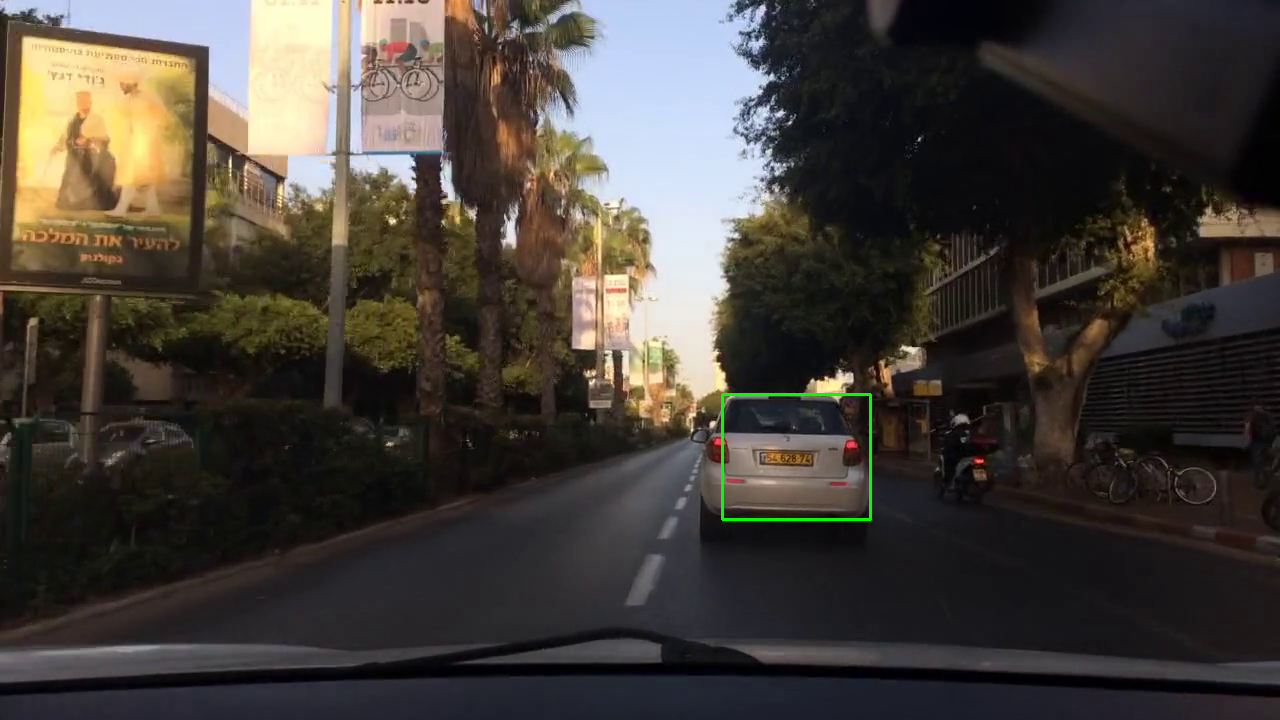

[Tracking] Frame 1203 time 0.4749448299407959
### No more frame ###
Elapsed time 571.8101770877838


In [18]:
frame_count = 0
# initialize the video writer 
writer = None
output_name = 'output_tracking.avi'

detected = False
frame_mode = 'Tracking'
elapsed_time = 0
trackers = cv2.MultiTracker_create()

# csrt
tracker = cv2.TrackerCSRT_create()
# kcf
#tracker = cv2.TrackerKCF_create()
# boosting
# tracker = cv2.TrackerBoosting_create()
# mil
# tracker = cv2.TrackerMIL_create()
# tld
# tracker = cv2.TrackerTLD_create()
# medianflow
# tracker = cv2.TrackerMedianFlow_create()
# mosse
#tracker = cv2.TrackerMOSSE_create()



vs = cv2.VideoCapture(file_name)



while True:
    start_time = time.time()
    frame_count += 1
    ret, frame = vs.read()
    if frame is None:
        print('### No more frame ###')
        break
    IPython.display.clear_output(wait=True)
    if detected:
        frame_mode = 'Tracking'
        (success, boxes) = trackers.update(frame)
        for box in boxes:
           (x, y, w, h) = [int(v) for v in box]
           cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else:
        frame_mode = 'Detection'
        height, width, channedls = frame.shape
        # Detecting objects
        # https://docs.opencv.org/master/d6/d0f/group__dnn.html
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        # Region of Interest
        roi_left = int(0.3 * width)
        roi_right = int(0.6 * width)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
        font = cv2.FONT_HERSHEY_COMPLEX
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                # Eliminate Small object(<50)
                if (w > 50) and (x > roi_left) and (x < roi_right):
                    selected = boxes[i]
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 5)    
        trackers.add(tracker, frame, tuple(selected))
        detected = True 

    cv2_imshow(frame)
    writeFrame(frame)
    frame_time = time.time() - start_time
    elapsed_time += frame_time
    print("[{}] Frame {} time {}".format(frame_mode, frame_count, frame_time))

print("Elapsed time {}".format(elapsed_time))
vs.release()          

In [19]:
from google.colab import files
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>